#Titanic Survival Prediction
**Introduction**

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean on 15th April, 1912. In this accident, more than 1500 out of the estimated total 2224 passengers and crew died, making it one of the most severe peacetime maritime disasters in modern history. This story was also filmed by director Steven Spielberg in to the movie Titanic, which was considered as one of the best movie in the 20th centery. As one of the major reasons of a such loss of life was the lack of the lifeboats, the survival chance was not determined randomly, but mostly the opportunity to acquire a spot on the lifeboats, which is influenced by several parameters. In this study, we estimate how do parameters such as sex, age, social class influence the survival chance.

**Table of Contents:**

1. Import libraries
2. Import data
3. Data cleaning, feature engineeirng, data visualization
4. Establishing the model
5. Model Implementation
   * Logistic regression
   * linear supporter vector classifier
   * PerceptronNaive Bayes
   * Support vector classifier
   * K-nearest neighbors
   * Decision tree
   * Random forest
   * Gradient boost classifier
6. Model ensembling
7. Prediction and submit the data

**1. Import libraries**

In [93]:
import sys #access to sysem parameters
import pandas as pd #collection of functions for data processing and alaysis 
pd.set_option('display.max_columns',None)
import numpy as np #foundation package for scientific computing
np.set_printoptions(threshold=np.inf)
import sklearn #collection of machine learning algorithms
import matplotlib.pyplot as plt #collection of functions for visualization
import scipy as sp #collection of functions for scientific computing and advance mathematics

#import IPython
#from Iphython import display # pretty printing of dataframes in Jupyter notebook
#misc libraries
import random
import time
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

###load data modelling libraries
#Common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
#Common model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

###Visualization
import matplotlib as mpl
#import matplotlib.pylot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure visualization defaults
#%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8

**2. Import data**

Here, we can see that the data contains features including:

* PassingerID: which is used to index the data and do not have obvious relationship with other features, data is complete
* Survived: the classification in this project, data is complete for training data
* Pclass: ticket class, which is largely determined by the social class, data is complete
* Sex and Age: which can potentially influence the survival rate as women and kids may have higher priority to get help in ethics. Sex feature is complete while the age feature lacks 177 values in the training data and 86 in the test data.
* Sibsp and Parch: # of siblins/sponses and parents/children aboard the Titanic, influence to the survival unknown, data is complete
* Ticket: relationship unkown, data is complete
* Fare: fare should be determined by the pclass, cabin, and embarked, data is complete in training data while have 1 missing value in the test data
* Cabin: may provide insight together with pclass, fare, embarked, however, this features have 687 missing values in the training data, so we will not use it directly in the model
* Embarked: have 2 missing values in the training data, will be filled in later

In [94]:
data_raw = pd.read_csv('./all_data/train.csv')
#891 passengers in the training set
data_val = pd.read_csv('./all_data/test.csv')
#418 passengers in the test set

#print (train.info())
#create a copy for the train data
#data1 = data_raw.copy(deep = True)
combine = [data_raw, data_val]

data_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [95]:
# Check for the missing values
print('Train columns with null values:\n', data_raw.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


**3. Data cleaning, feature engineering, data visualization**

In this section we are going to do some exploratory data analysis with descriptive and graphical methods. The features of interest fall into the following categories:

1. Pclass, Fare, Embarked, Cabin, Ticket: which can be used to fill in missing embarked and fare values
2. Sex, Name (with Title), Age, SibSp, Parch: which can be used to fill in missing age values

**Category 1: Pclass, Fare, Embarked, Cabin, Ticket**

Missing values: 2 Embarked values, 1 Fare value, 1014 Cabin values


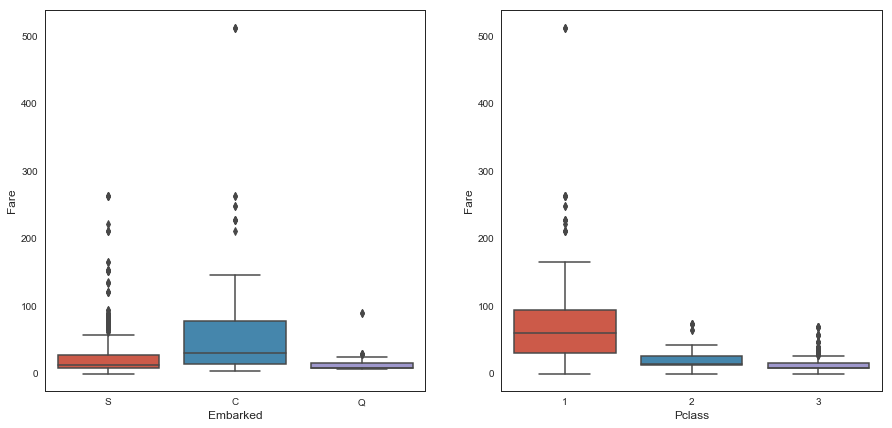

In [96]:
###Visualize embarkment, Pclass, fare
plt.figure(figsize=[15,7])

plt.subplot(121)
sns.boxplot(x = 'Embarked', y = 'Fare', data = data_raw)
#Passengers embarked at C tend to pay higher fare
plt.subplot(122)
sns.boxplot(x = 'Pclass', y = 'Fare', data = data_raw)
#Passengers from higher class tend to pay higher fare

We noticed that several cabin features are missing, we assume that one important reason for the value missing is that they did not survived so there is no record. To prove our hypothesis, we establish a new feature to indicate if the cabin feature is missing and to study their relationship with the survival rate.

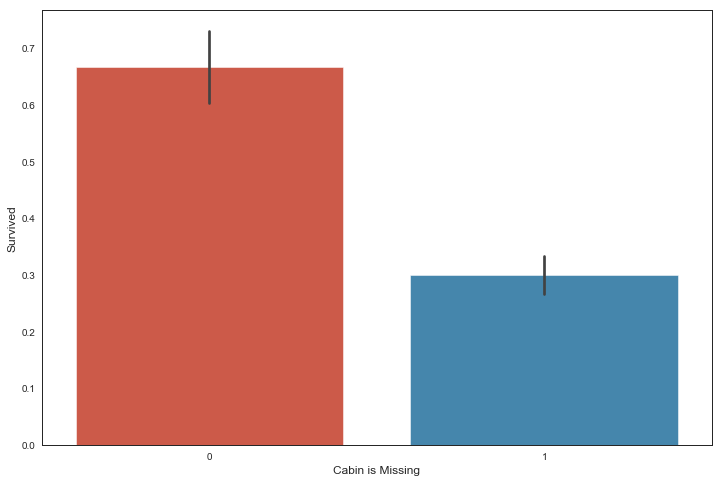

<Figure size 504x504 with 0 Axes>

In [97]:
for dataset in combine:
    dataset['Cabin_null'] =data_raw['Cabin'].isnull()*1
age_survive = sns.barplot(x='Cabin_null', y='Survived', data=data_raw)
age_survive = plt.xlabel('Cabin is Missing')
age_survive = plt.ylabel('Survived')
plt.figure(figsize=[7,7])
plt.show()

The 2 missing Embarked values are filled with the most frequent value for the Embarked feature. 

Since Fare feature is very related to the pclass feature, the 1 missing Fare value is filled in with the mean Fare value for the pclass the passenger belongs to.

In [98]:
###Complete the missing values
# The missing Embarked data is filed in with the most frequent value
for dataset in combine:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace = True) # The missing embarked data is filled in with mode
    #dataset['Fare'].fillna(dataset['Fare'].median(),inplace = True) # The missing fare data is filled in with median 
    
# The missing Fare data is filled in with the mean fare value for the pclass the passenger belongs to 
for x in range(len(data_val["Fare"])):
    if pd.isnull(data_val["Fare"][x]):
        pclass = data_val["Pclass"][x] #Pclass = 3
        data_val["Fare"][x] = round(data_raw[data_raw["Pclass"] == pclass]["Fare"].mean(), 4)

A new feature FareBin is created.

The first letter of the Cabin is extracted and stored as the Cabin feature.

In [99]:
###Feature engineering
#Create the FareBin feature
#Keep the first letter for Cabin data
Fare_Bins=[-1,7.91,14.454,31,10000]
Fare_Labels=['cheap','medium','medium high','high']

for dataset in combine:
    dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
    dataset['FareBin']=pd.cut(dataset['Fare'], Fare_Bins, labels=Fare_Labels)

data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_null,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,cheap
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0,high
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,1,medium
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0,high
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,1,medium


The figures showing survival rate ploted as functions of Pclass, Embarked, Cabin, FareBin are shown as below.

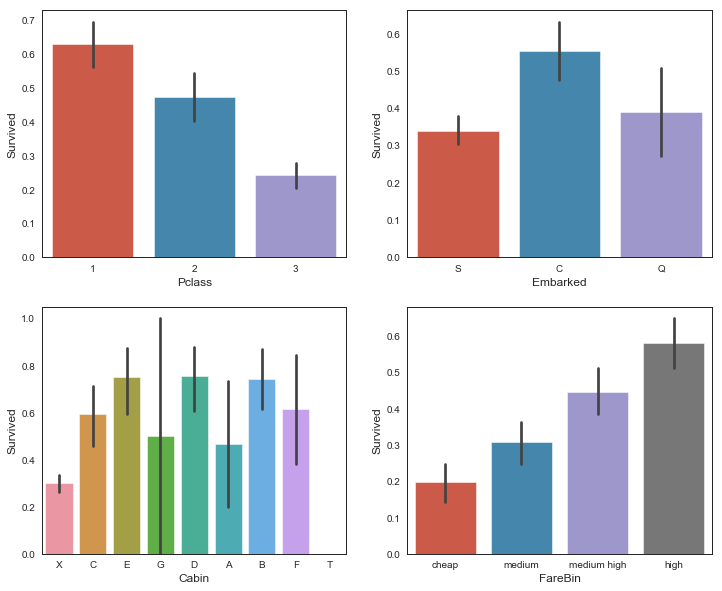

In [100]:
###Data visualization

plt.figure(figsize=[12,10])

plt.subplot(221)
sns.barplot(x = 'Pclass', y = 'Survived', data = data_raw)
#People with higher socieconomic class had a higher rate of survival

plt.subplot(222)
sns.barplot(x = 'Embarked', y = 'Survived', data = data_raw)
#People embarked at C are more likely to survive

plt.subplot(223)
sns.barplot(x='Cabin',y='Survived',data = data_raw)
#People with a recorded Cabin number are more likely to survive

plt.subplot(224)
sns.barplot(x='FareBin',y='Survived',data = data_raw)
#People who pay a higher fare are more likely to survive

The FareBin feature is converted into numbers.

In [101]:
###Convert the features into numbers
#cleanup_Embarked = {'S':0,'C':1,'Q':2}
cleanup_FareBin ={'cheap':0,'medium':1,'medium high':2,'high':3}
for dataset in combine:
    #dataset['Embarked']=dataset['Embarked'].map(cleanup_Embarked).astype(int)
    dataset['FareBin']=dataset['FareBin'].map(cleanup_FareBin).astype(int)

data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_null,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,1,1


The prefix part of the ticket feature is extracted and stored as the ticket feature.

In [102]:
# For ticket feature we only keep the prefix part
for dataset in combine:
    Ticket = []
    for i in list(dataset.Ticket):
        if not i.isdigit() :
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            Ticket.append("X")
    dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0    X
1    X
2    X
3    X
4    X
Name: Ticket, dtype: object

**Category 2: Sex, Age, SibSp, Parch**

Missing values: 177 Age values

**Feature: Age**

Firstly, let us have a look at the relationship between the age and the survival rate. It is interesting to discovered that babies of age 0-5 have a higher chance to survive, while at the same time, elderly passengers who are order than 65 have the survival rate as low as only ~10%.

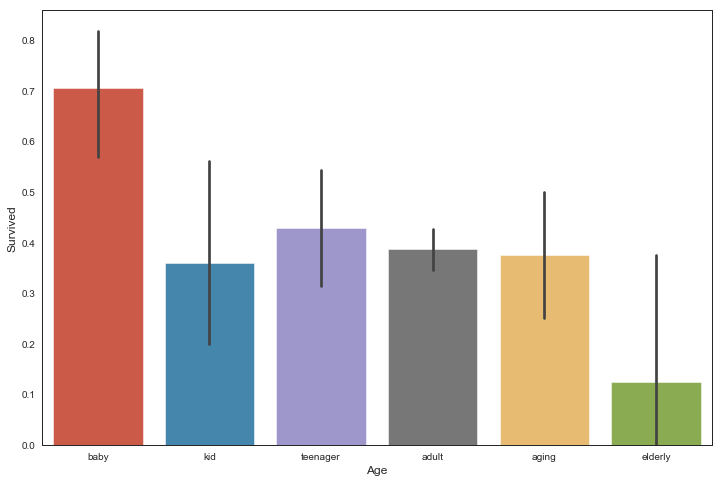

<Figure size 504x360 with 0 Axes>

In [103]:
age_bins=[0,5,12,18,50,65,120]
age_labels=['baby','kid','teenager','adult','aging','elderly']
for dataset in combine:
    dataset['AgeGroup']=pd.cut(dataset['Age'], age_bins, labels=age_labels)
age_survive = sns.barplot(x='AgeGroup', y='Survived', data=data_raw)
age_survive = plt.xlabel('Age')
age_survive = plt.ylabel('Survived')
plt.figure(figsize=[7,5])
plt.show()

We noticed that several age features are missing, we assume that one important reason for the value missing is that they did not survived so there is no record. To prove our hypothesis, we establish a new feature to indicate if the age feature is missing and to study their relationship with the survival rate.

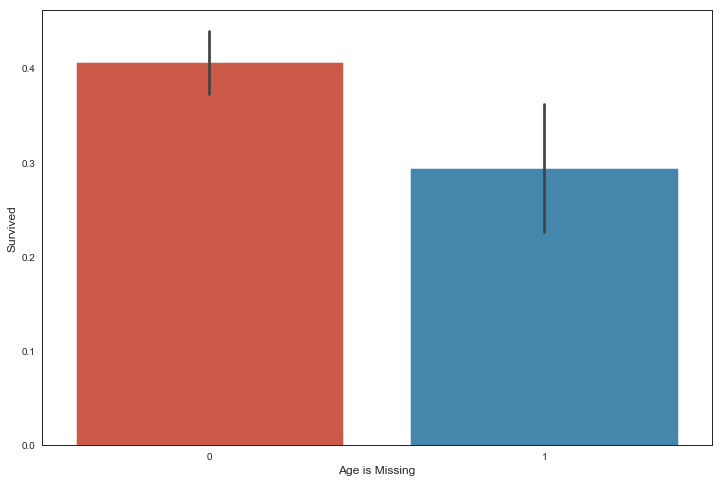

In [104]:
for dataset in combine:
    dataset['Age_null'] =data_raw['Age'].isnull()*1
age_survive = sns.barplot(x='Age_null', y='Survived', data=data_raw)
age_survive = plt.xlabel('Age is Missing')
age_survive = plt.ylabel('Survived')
plt.show()

We noticed that in the name, there is title information. As different titles usually refer to different age ranges, the title information can help us to predict the age features. So we extract this informatino from the name and save it in a new feature named 'title'.

In [105]:
# Complete missing age Values. we noticed that in the name, there is also title information, this can be helpful to predict the age
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(data_raw['Title'], data_raw['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [106]:
# Group different title (especially rare titles) into common groups which are more closely related to the age
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Sir', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Rev', 'Countess', 'Lady', 'Dona'], 'Rare')
#     dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Dona'], 'Rare_F')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch'] + 1
    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
pd.crosstab(data_raw['Title'], data_raw['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


According to our common sense, the title should be related to the age, e.g. title Miss should be younger than Mrs. To identify if the title is related to the title, we visualize their relationship.

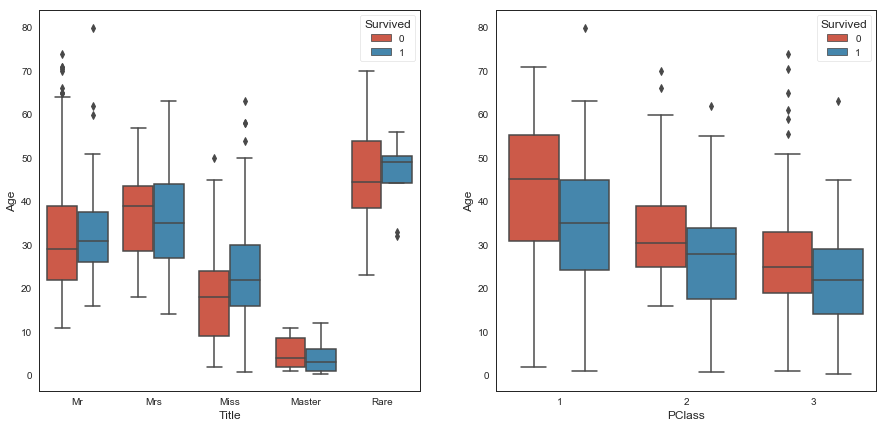

In [107]:
# According to our common sense, the title should be related to the age, e.g. title Miss should be younger than Mrs. To identify if the title is related to the title, visualize their relationship
plt.figure(figsize=[15,7])
plt.subplot(121)
age_title = sns.boxplot(x="Title", y="Age",hue="Survived", data=data_raw)
age_title = plt.xlabel('Title')
age_title = plt.ylabel('Age')
# We assume the age is also related to the pclass so we plot the corresponding diagram to confirm
plt.subplot(122)
age_title = sns.boxplot(x="Pclass", y="Age",hue="Survived", data=data_raw)
age_title = plt.xlabel('PClass')
age_title = plt.ylabel('Age')
plt.show()

According to the above analysis, the age value is related to both the title and the pclass, as we hypothesized initially. It is also interesting to discovered that in all pclass group, survived people are of younger median age than dead ones. So we assign the median of each [title, pclass] group if the age value is missed.

In [108]:
# assign the median of each [title, pclass] group if the age value is missed
def impute_age(dataset):
   for pclass in [1,2,3]:
        for title in ['Master','Miss','Mr','Mrs','Rare']:
            ds=dataset[dataset['Pclass']==pclass]
            ds=ds[ds['Title']==title]
            median=ds['Age'].median()
            dataset.loc[
                (dataset['Age'].isnull())&
                (dataset['Pclass']==pclass)&
                (dataset['Title']==title),
                'Age'
            ]=median
impute_age(data_raw)
impute_age(data_val)

**Feature SibSp and Parch**

Both these features represent the number of relatives on the Titanic, so we create a new feature to represent the size of the family for each passengers.

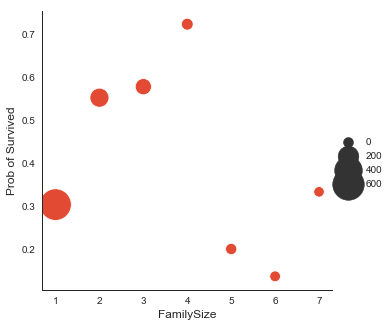

In [109]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch'] + 1

# to study the influence of the family size to the survival chance and the distributino of different family size, 
# we use the bubble plot to visualize it. The size of each bubble is count of each family size.
fs_count = data_raw['FamilySize'].value_counts()
fs_prob_survived = data_raw['FamilySize'][data_raw['Survived'] == 1].value_counts()
fs_prob = fs_prob_survived/fs_count
familysize = sns.relplot(fs_prob.index, fs_prob.values, size = fs_count.values, sizes = (100,1000), data=data_raw)
plt.xlabel('FamilySize')
plt.ylabel('Prob of Survived')
plt.show()

Here we can learn that if you have a family size of 2-4, you will in geneneral have a higher chance to survive. However, it is noted that as passengers with family size 4 or higher are limisted, there might be bias here. 


**Feature Sex**

As can be seen below, over 70% of female passengers are survived while only ~20% male are survived. Thank you gentlemen!

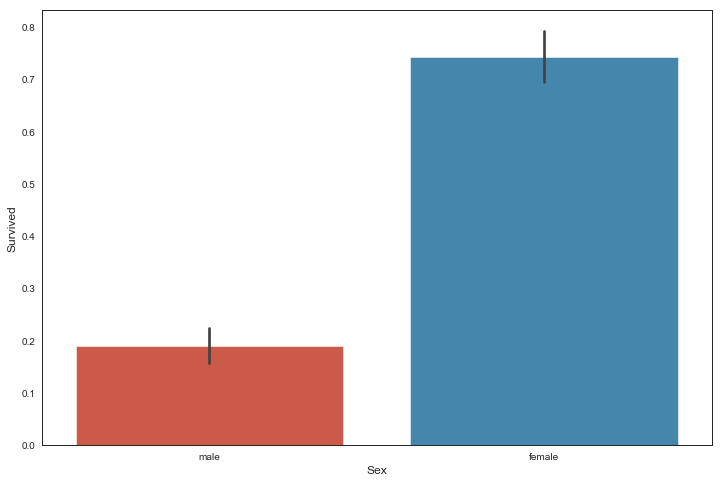

In [110]:
sns.set_style("white")
sex_sur = sns.barplot(x="Sex", y="Survived", data=data_raw)
sex_sur = plt.xlabel('Sex')
sex_sur = plt.ylabel('Survived')
plt.show()

In [111]:
#for dataset in combine:
 #   dataset["Age"] = dataset["Age"].fillna(-0.5)

age_bins=[0,5,12,18,50,65,120]
age_labels=['baby','kid','teenager','adult','aging','elderly']
for dataset in combine:
    dataset['AgeGroup']=pd.cut(dataset['Age'], age_bins, labels=age_labels)

cleanup_agegroup = {'baby':1,'kid':2,'teenager':3,'adult':4,'aging':5,'elderly':6}
cleanup_sex = {'male':0,'female':1}
for dataset in combine:
    dataset['AgeGroup']=dataset['AgeGroup'].map(cleanup_agegroup).astype(int)
    dataset['Sex']=dataset['Sex'].map(cleanup_sex).astype(int)
data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_null,FareBin,AgeGroup,Age_null,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A5,7.2500,X,S,1,0,4,0,Mr,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC,71.2833,C,C,0,3,4,0,Mrs,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STONO2,7.9250,X,S,1,1,4,0,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,X,53.1000,C,S,0,3,4,0,Mrs,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,X,8.0500,X,S,1,1,4,0,Mr,1,1


**4. Establishing the model**

To establish our model, we drop features including name, passenger ID  as they can hardly provide new insights (we already took out the title features)
We establish two types of model dealing with the age and fare information: in type 1, we keep the numerical age and fare and drop the agegroup and farebin features. in type 2, we instead use the agegroup and farebin to represent the age and fare.
as we use agegroup instead, sibsp and parch as we used family size instead, and Fare as we think it is determined by the pclass and embarked features. 

In [112]:
# First we combine the training data and test dat in order to get the same number of dummy features when using one hot encoded
# to deal with the training data and test data together, we firstly separate features and labels in training data into data_raw and Y_train 
Y_train = data_raw["Survived"]
drop_column = ['Survived']
data_raw.drop(drop_column, axis=1, inplace=True)

data_raw_len = len(data_raw)
dataset_comb =  pd.concat(objs=[data_raw, data_val], axis=0).reset_index(drop=True)

In [113]:
# in feature group1, we drop ['Name','AgeGroup','PassengerId','FareBin','Ticket','Cabin'] to use numerical age and fare for the model
# in feature group2, instead we drop ['Name','Age','PassengerId','Fare','FamilySize','Cabin']

Feature_Group1 = ['Pclass','Sex','Age','Age_null', 'FamilySize','SibSp', 'Parch','Fare','Cabin_null','Embarked', 'Title', 'IsAlone']

dataset1 = dataset_comb[Feature_Group1]

dataset1.head()

,Pclass,Sex,Age,Age_null,FamilySize,SibSp,Parch,Fare,Cabin_null,Embarked,Title,IsAlone
0,3,0,22.0,0,2,1,0,7.2500,1,S,Mr,0
1,1,1,38.0,0,2,1,0,71.2833,0,C,Mrs,0
2,3,1,26.0,0,1,0,0,7.9250,1,S,Miss,1
3,1,1,35.0,0,2,1,0,53.1000,0,S,Mrs,0
4,3,0,35.0,0,1,0,0,8.0500,1,S,Mr,1


In [114]:
# As for title and embarked features, 
# each different types of values should be of the same weight, 
# we encode them by one hot encoder to transfer each possible value into a boolean type
from sklearn.preprocessing import OneHotEncoder
one_hot_encoded_dataset1 = pd.get_dummies(dataset1)
one_hot_encoded_dataset1.head()

,Pclass,Sex,Age,Age_null,FamilySize,SibSp,Parch,Fare,Cabin_null,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,0,22.0,0,2,1,0,7.2500,1,0,0,0,1,0,0,1,0,0
1,1,1,38.0,0,2,1,0,71.2833,0,0,1,0,0,0,0,0,1,0
2,3,1,26.0,0,1,0,0,7.9250,1,1,0,0,1,0,1,0,0,0
3,1,1,35.0,0,2,1,0,53.1000,0,0,0,0,1,0,0,0,1,0
4,3,0,35.0,0,1,0,0,8.0500,1,1,0,0,1,0,0,1,0,0


Previously I noticed that some fare are extremely large, in which case the very large values may negatively affect the performance of the algorithm, so I log transform the fare feature firsly. Then I standardardize the age and fare features.

In [115]:
from sklearn.preprocessing import MinMaxScaler
dataset1['Fare'] = dataset1['Fare'].apply(lambda x: np.log(x + 1))
one_hot_encoded_dataset1[['Age', 'Fare']] = MinMaxScaler().fit_transform(dataset1[['Age', 'Fare']])


In [116]:
X_train = one_hot_encoded_dataset1[:data_raw_len]
X_test = one_hot_encoded_dataset1[data_raw_len:]

X_train.head()

,Pclass,Sex,Age,Age_null,FamilySize,SibSp,Parch,Fare,Cabin_null,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,0,0.273456,0,2,1,0,0.338125,1,0,0,0,1,0,0,1,0,0
1,1,1,0.473882,0,2,1,0,0.685892,0,0,1,0,0,0,0,0,1,0
2,3,1,0.323563,0,1,0,0,0.350727,1,1,0,0,1,0,1,0,0,0
3,1,1,0.436302,0,2,1,0,0.639463,0,0,0,0,1,0,0,0,1,0
4,3,0,0.436302,0,1,0,0,0.352955,1,1,0,0,1,0,0,1,0,0


To establish our model, we split the training data into training set and development set with the ratio 75:25

In [117]:
from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

**5. Model implementation**

In this problem, we care the most about the accuracy of the model, thus we used the accuracy as the evaluation metrics. We compare the result of following result:

* Logistic Regression
* Decision Tree
* Gaussian Naive Bayes
* Support Vector Machines (SVM)
* K-Nearest Neighbors
* Ensemble Methods including Bagging, AdaBoost, Random Forest, Gradient Boosting

In [118]:
from sklearn.metrics import accuracy_score
from time import time

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test and train set(X_test),
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end-start
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Success
    print("{} trained on samples.".format(learner.__class__.__name__))
        
    # Return the results
    return results





LogisticRegression trained on samples.
Perceptron trained on samples.
DecisionTreeClassifier trained on samples.
GaussianNB trained on samples.
SVC trained on samples.
KNeighborsClassifier trained on samples.
AdaBoostClassifier trained on samples.
BaggingClassifier trained on samples.
RandomForestClassifier trained on samples.
GradientBoostingClassifier trained on samples.


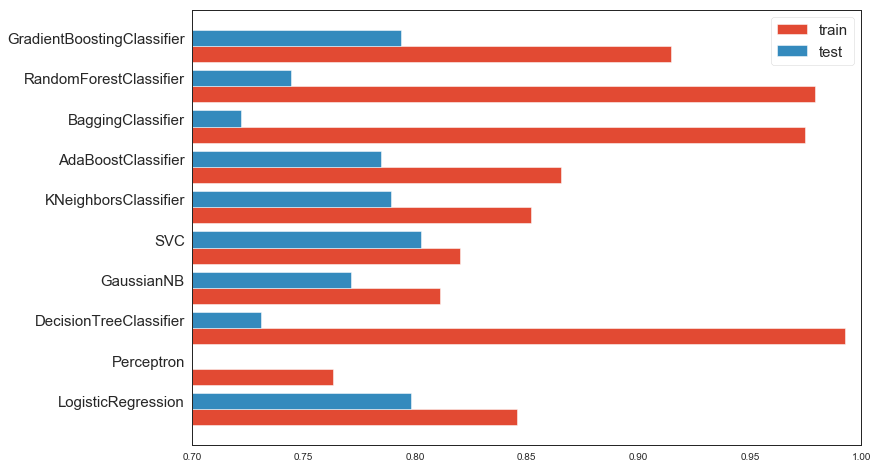

In [119]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier


# initialize all models

model_1 = LogisticRegression()
model_2 = Perceptron()
model_3 = DecisionTreeClassifier()
model_4 = GaussianNB()
model_5 = SVC(kernel='rbf',gamma=0.001,C=10)
model_6 = KNeighborsClassifier()
model_7 = AdaBoostClassifier()
model_8 = BaggingClassifier()
model_9 = RandomForestClassifier()
model_10 = GradientBoostingClassifier()

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]
results = {}
model_names = []
train_accuracies = []
test_accuracies = []

for model in models:
    results[model.__class__.__name__] = train_predict(model, x_train, y_train, x_dev, y_dev)
    model_names.append(model.__class__.__name__)
    train_accuracies.append(results[model.__class__.__name__]['acc_train'])
    test_accuracies.append(results[model.__class__.__name__]['acc_test'])    


# Plot and compare the accuracy of different models
plt.figure(figsize=[12,8])
barWidth = 0.4
plt.xlim(0.7, 1)
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.barh(r1, train_accuracies, height=barWidth, edgecolor='white', label='train')
plt.barh(r2, test_accuracies,  height=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.yticks([r + barWidth for r in range(len(models))], model_names, fontsize = 15)
plt.legend(fontsize= 15)
 
# Create legend & Show graphic

plt.show()



According to the above result, ensemble methods and decision tree are overfitting. To find the best model, I will tune hyperparameters of these models to find their best performance.

In [120]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def grid_search(learner, parameters, X_train, y_train, X_test, y_test, search = 'GridSearchCV'): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - parameters: the library of the hyperparameters to tune
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    scorer = make_scorer(accuracy_score)
    
    start = time() # Get start time
    if search == 'GridSearchCV':
        grid_fit = GridSearchCV(learner, parameters, scorer).fit(X_train, y_train)
    elif search == 'RandomizedSearchCV':
        grid_fit = RandomizedSearchCV(learner, parameters, scorer).fit(X_train, y_train)
    best_model = grid_fit.best_estimator_
    best_model.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test and train set(X_test),
    start = time() # Get start time
    predictions_test = best_model.predict(X_test)
    predictions_train = best_model.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end-start
    results['best_model'] = best_model
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Success
    print("{} trained on samples.".format(learner.__class__.__name__))
        
    # Return the results
    return results







DecisionTreeClassifier trained on samples.
AdaBoostClassifier trained on samples.
BaggingClassifier trained on samples.
GradientBoostingClassifier trained on samples.
RandomForestClassifier trained on samples.


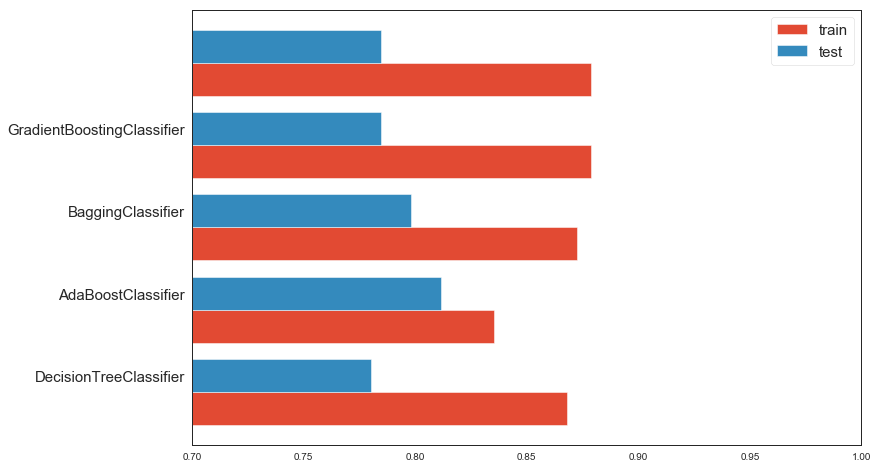

In [129]:

model_11 = DecisionTreeClassifier()
parameters_11 = {'max_depth':range(1,10), 'min_samples_split':range(2,20), 'min_samples_leaf':range(2,20)}
model_12 = AdaBoostClassifier()
parameters_12 = {"n_estimators":[10, 100, 200],
             "learning_rate":[0.001, 0.005, .01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 10, 20]}
model_13 = BaggingClassifier()
parameters_13 = {'n_estimators':[5,10,50,100], 'max_samples':[0.2, 0.5, 1], 'max_features':[0.5, 1]}
model_14 = RandomForestClassifier()
parameters_14 = {"max_depth": [1,2,3,4,5,6,7,8,9,10], "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11))}
model_15 = GradientBoostingClassifier()
parameters_15 = {'max_depth': [1,2,3,4,5], 'min_samples_leaf': [10, 20, 50, 100, 200], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5]}

models = [model_11, model_12, model_13, model_15]
parameterses = [parameters_11, parameters_12, parameters_13, parameters_15]
results = {}
model_names = []
train_accuracies = []
test_accuracies = []

i = 0
for model in models:
    results[model.__class__.__name__] = grid_search(model, parameterses[i], x_train, y_train, x_dev, y_dev)
    model_names.append(model.__class__.__name__)
    train_accuracies.append(results[model.__class__.__name__]['acc_train'])
    test_accuracies.append(results[model.__class__.__name__]['acc_test'])
    i += 1


results[model_14.__class__.__name__] = grid_search(model_14, parameters_14, x_train, y_train, x_dev, y_dev)
model_names.append(model.__class__.__name__)
train_accuracies.append(results[model.__class__.__name__]['acc_train'])
test_accuracies.append(results[model.__class__.__name__]['acc_test'])    

    
    
# Plot and compare the accuracy of different models

plt.figure(figsize=[12,8])
barWidth = 0.4
plt.xlim(0.7, 1)
r1 = np.arange(len(models)+1)
r2 = [x + barWidth for x in r1]
bar_1 = plt.barh(r1, train_accuracies, height=barWidth, edgecolor='white', label='train')
bar_2 = plt.barh(r2, test_accuracies,  height=barWidth, edgecolor='white', label='test')
plt.yticks([r + barWidth for r in range(len(models))], model_names, fontsize = 15)
plt.legend(fontsize= 15)



plt.show()



In [130]:
print(results['AdaBoostClassifier'])

{'train_time': 23.08125638961792, 'pred_time': 0.02991938591003418, 'best_model': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=100, random_state=None), 'acc_train': 0.8353293413173652, 'acc_test': 0.8116591928251121}


#### According the above discussion:
the best result is achieved through the AdaBoostClassifier

|     Metric     | Accuracy_train | Accuracy_test |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.83532                |      0.81165           |


#### Next we will explore the feature relevance 

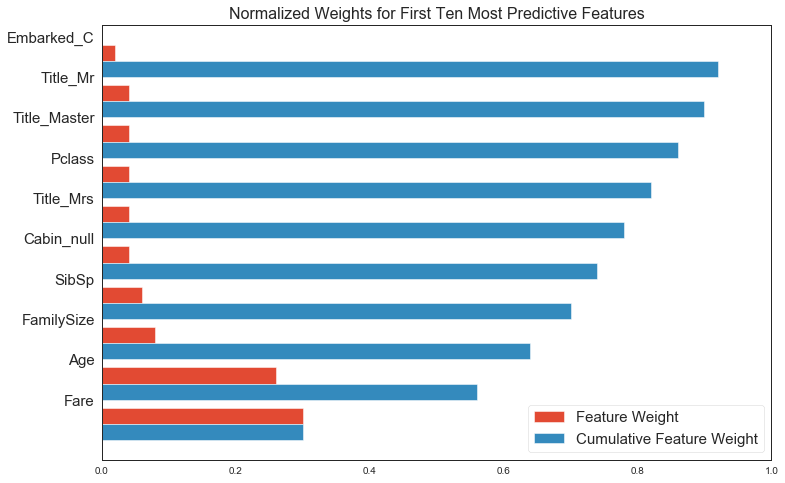

In [131]:
model = AdaBoostClassifier()
model.fit(x_train, y_train)
importances = model.feature_importances_


indices = np.argsort(importances)[::-1]
columns = x_train.columns.values[indices[:10]]
values = importances[indices][:10]

plt.figure(figsize=[12,8])
barWidth = 0.4
plt.xlim(0, 1)
r1 = np.arange(10)
r2 = [x - barWidth for x in r1]
bar_1 = plt.barh(r1, values, height=barWidth, edgecolor='white', label="Feature Weight")
bar_2 = plt.barh(r2, np.cumsum(values),  height=barWidth, edgecolor='white', label="Cumulative Feature Weight")
plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
plt.yticks([r + barWidth for r in range(10)], columns, fontsize = 15)
plt.legend(fontsize= 15)
plt.show()

According to the above result, we can see that fare, age, and family size are three most predictive features for the final survival chance. 